In [92]:
# Imports
import pandas as pd
import seaborn as sns
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.estimators import ParameterEstimator, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
import networkx as nx
import pickle
import matplotlib.pyplot as plt

## Bayesian Network

In [93]:
# Loead the cleaned dataset
df = pd.read_csv('./Datasets/social.csv')

# Load the disìctionary for interpreting labels
with open('label_encodings.pkl', 'rb') as pickle_file:
    label_encodings = pickle.load(pickle_file)

In [94]:
df

,cluster_age,gender,time_spent,platform,interests,location,demographics,profession,cluster_income,indebt,isHomeOwner,Owns_Car
0,0,1,3,1,1,1,2,1,0,1,0,0
1,2,0,2,0,2,1,2,2,2,1,1,1
2,1,1,8,1,1,0,1,0,1,0,0,0
3,0,2,5,1,2,1,2,2,2,0,1,0
4,1,1,1,1,0,0,2,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,0,8,1,0,1,0,0,0,0,1,0
996,2,2,6,2,2,1,0,1,2,1,0,0
997,1,2,5,2,2,1,0,2,0,1,0,1
998,0,0,4,2,1,0,1,0,1,1,1,0


In [95]:
# We build the Bayesian Network
model = BayesianNetwork([
    ('cluster_age', 'cluster_income'),
    ('gender', 'cluster_income'),
    ('time_spent', 'platform'),
    ('platform', 'interests'),
    ('interests', 'Owns_Car'),
    ('location', 'demographics'),
    ('demographics', 'cluster_income'),
    ('profession', 'cluster_income'),
    ('cluster_income', 'indebt'),
    ('isHomeOwner', 'indebt'),
    ('Owns_Car', 'indebt')
])

model.fit(df, estimator=MaximumLikelihoodEstimator)

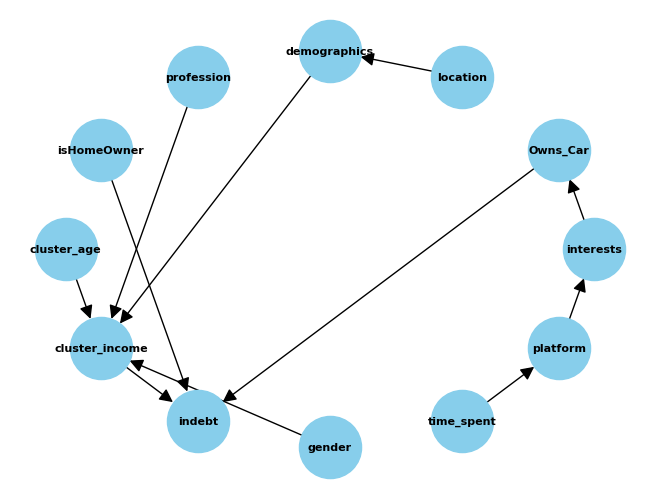

In [96]:
# We show the graph
edges = model.edges()

G = nx.DiGraph()
G.add_edges_from(edges)

# Use shell_layout for an ordered arrangement
# nx.arf_layout(G) --> sparse
# nx.shell_layout(G) --> in circle
# nx.planar_layout(G) --> sparse
# nx.spiral_layout(G) --> spiral
# nx.random_layout(G) --> random
# nx.spring_layout(G) --> random

pos = nx.shell_layout(G)

nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=2000, node_color="skyblue", font_size=8, arrowsize=20)
plt.show()

In [97]:
# Print all the learned CPTs
for cpd in model.get_cpds():
    print('CPT of {}'.format(cpd.variable))
    print(cpd, '\n')

CPT of cluster_age
+----------------+-------+
| cluster_age(0) | 0.289 |
+----------------+-------+
| cluster_age(1) | 0.353 |
+----------------+-------+
| cluster_age(2) | 0.358 |
+----------------+-------+ 

CPT of cluster_income
+-------------------+-----+---------------------+
| cluster_age       | ... | cluster_age(2)      |
+-------------------+-----+---------------------+
| demographics      | ... | demographics(2)     |
+-------------------+-----+---------------------+
| gender            | ... | gender(2)           |
+-------------------+-----+---------------------+
| profession        | ... | profession(2)       |
+-------------------+-----+---------------------+
| cluster_income(0) | ... | 0.5454545454545454  |
+-------------------+-----+---------------------+
| cluster_income(1) | ... | 0.0                 |
+-------------------+-----+---------------------+
| cluster_income(2) | ... | 0.45454545454545453 |
+-------------------+-----+---------------------+ 

CPT of gender
+-

## Queries

In [98]:
inference = VariableElimination(model)

# Query: Qual è la probabilità di essere in debito dato il reddito e il fatto che l'utente possiede una casa?
query_result = inference.query(variables=['Owns_Car'], evidence={'time_spent' : 1, 'platform' : label_encodings['platform']['Facebook'], 'interests' : label_encodings['interests']['Lifestlye']})

# Visualizza i risultati
print(query_result)

+-------------+-----------------+
| Owns_Car    |   phi(Owns_Car) |
+=============+=================+
| Owns_Car(0) |          0.5044 |
+-------------+-----------------+
| Owns_Car(1) |          0.4956 |
+-------------+-----------------+
